In [89]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib inline

import numpy as np 

import os 

matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/data_cleaned_newfilt_subj_01k101k1.mat'


In [5]:
from andante_pd_ft2mne import import2mne  

mneEpochs = import2mne(matfile)
mneEpochs_short = mneEpochs.crop(tmin=-0.05,tmax=0.15)

In [7]:
evoked = mneEpochs.average()

<IPython.core.display.Javascript object>


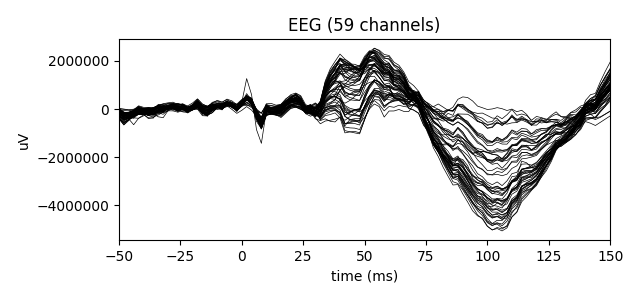

In [85]:
evoked.plot()
plt.show()

In [87]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator
from mne.decoding import CSP


epochs = mneEpochs_short[['iso_std','rnd_std']]
#epochs = mneEpochs_short[['iso_dev','rnd_dev']]
#epochs = mneEpochs_short[['iso_std','iso_dev']]


clf = make_pipeline(StandardScaler(),LogisticRegression())

time_gen = GeneralizingEstimator(clf, scoring='accuracy', n_jobs=1)

# Get the labels
labels = epochs.events[:, -1]

# Cross validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Do cross-validation
scores = []

for train, test in cv.split(epochs, labels):
    
    time_gen.fit(X=epochs[train].get_data(), y=labels[train])
     
    scores.append(time_gen.score(X=epochs[test].get_data(),y=labels[test]))

scores = np.stack(scores) 


<IPython.core.display.Javascript object>


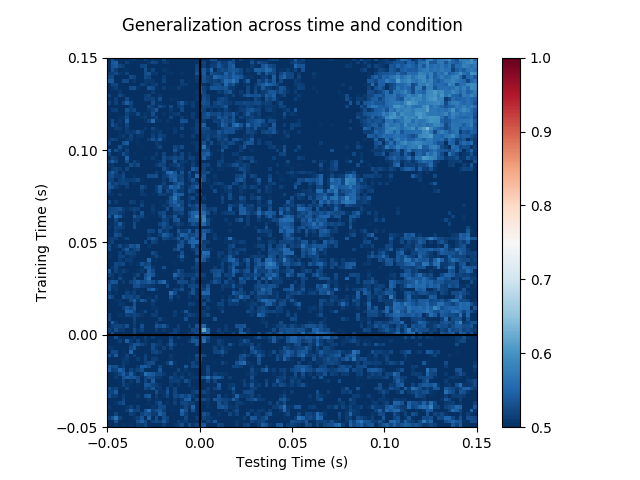

In [88]:
# Plot
fig, ax = plt.subplots(1)
im = ax.matshow(scores.mean(axis=0), cmap='RdBu_r', vmin=0.5,vmax=1,origin='lower',
                extent=epochs.times[[0, -1, 0, -1]])
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Generalization across time and condition')
plt.colorbar(im, ax=ax)
plt.show()

Test on all subjects 
--

In [130]:
datadir = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/'

import os 

allcontrols = os.listdir(os.path.join(datadir,'probands'))
allpatients = os.listdir(os.path.join(datadir,'patients'))

if not(os.path.isdir('timegen_controls')):
    print('Making probands timegen dir ')
    os.mkdir('timegen_controls')

if not(os.path.isdir('timegen_patients')):
    print('Making patients timegen dir ')
    os.mkdir('timegen_patients')

Making probands timegen dir 
Making patients timegen dir 


In [166]:
from andante_pd_ft2mne import import2mne  
from mne import Epochs,EpochsArray
from mne.channels import read_montage

def timegen_process(matfile,ncv=5,metric='accuracy'):
    subjid = matfile[-8:-4]
    print("Subject : %s " % subjid)
    
    ## Open file 
    mneEpochs = import2mne(matfile)
    mneEpochs_short = mneEpochs.crop(tmin=-0.05,tmax=0.15)
    
    
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)

    ## Perform Supervised Learning using Temporal Generalization 
    
    epochs = mneEpochs_short[['iso_std','rnd_std']]
    
    clf = make_pipeline(StandardScaler(),LogisticRegression())

    time_gen = GeneralizingEstimator(clf, scoring=metric, n_jobs=1)

    # Get the labels
    labels = epochs.events[:, -1]

    # Cross validator
    cv = StratifiedKFold(n_splits=ncv, shuffle=True, random_state=42)

    # Do cross-validation
    scores = []

    for train, test in cv.split(epochs, labels):

        time_gen.fit(X=epochs[train].get_data(), y=labels[train])

        scores.append(time_gen.score(X=epochs[test].get_data(),y=labels[test]))

    scores = np.stack(scores) 


    #Plot
    
    fig, (ax1,ax2) = plt.subplots(ncols=2)
    im = ax1.matshow(scores.mean(axis=0), cmap='RdBu_r', vmin=0.3,vmax=0.7,origin='lower',
                    extent=epochs.times[[0, -1, 0, -1]])
    ax1.axhline(0., color='k')
    ax1.axvline(0., color='k')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlabel('Testing Time (s)')
    ax1.set_ylabel('Training Time (s)')
    ax1.set_title('%s - %s - Std Reg Vs Irreg' % (subjid,metric))
    plt.colorbar(im, ax=ax1)
    
    ## Plot the ERP 
    
    from mne.viz import plot_compare_evokeds

    conditions = ["iso_std", "rnd_std"]
    
    evoked_dict = dict()
    for condition in conditions:
        evoked_dict[condition] = mneEpochs_short[condition].average()

    colors = dict(iso_std="Crimson", rnd_std="CornFlowerBlue")
    


    pick = mneEpochs_short.ch_names.index('Cz')

    
    plot_compare_evokeds(evoked_dict,colors=colors,picks=pick,axes=ax2)
    
    
    
    
    fig.subplots_adjust(wspace=0.9)
    fig.set_figwidth(8)
    fig.set_figheight(8)
    
    return fig,scores

Subject : 01k1 
657 matching events found
0 projection items activated
0 bad epochs dropped


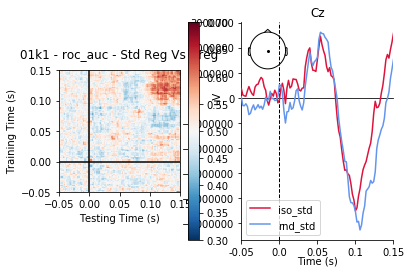

In [167]:
fig,scores= timegen_process(os.path.join(datadir,'probands',allcontrols[0]),metric='roc_auc',ncv=2)


In [171]:
fig.set_figwidth(8)
fig.set_figheight(8)
fig.savefig('test.png')

Subject : 01k1 
657 matching events found
0 projection items activated
0 bad epochs dropped


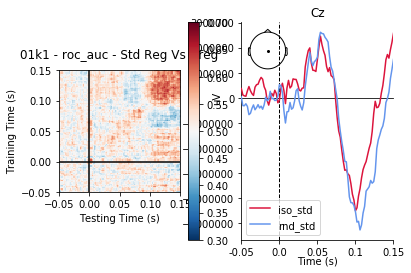

Subject : 02k1 
612 matching events found
0 projection items activated
0 bad epochs dropped


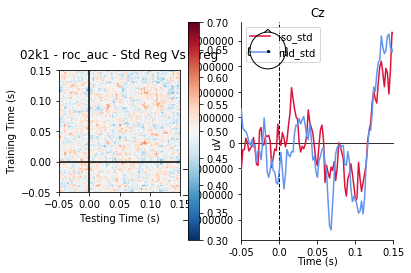

Subject : 03k1 
621 matching events found
0 projection items activated
0 bad epochs dropped


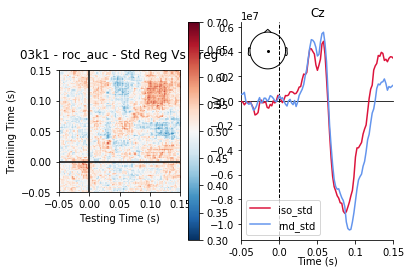

Subject : 04k1 
670 matching events found
0 projection items activated
0 bad epochs dropped


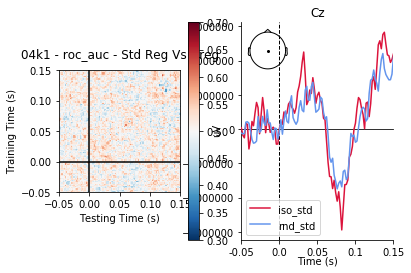

Subject : 05k1 
613 matching events found
0 projection items activated
0 bad epochs dropped


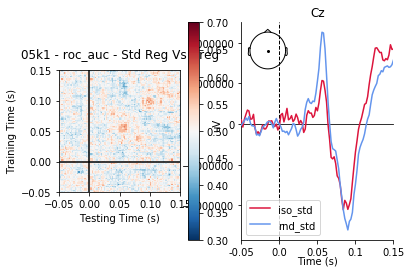

Subject : 06k1 
562 matching events found
0 projection items activated
0 bad epochs dropped


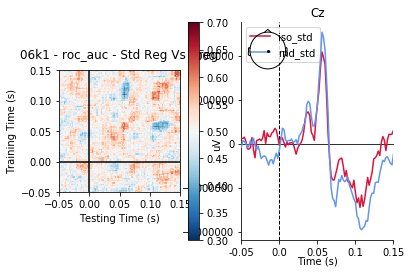

Subject : 07k1 
631 matching events found
0 projection items activated
0 bad epochs dropped


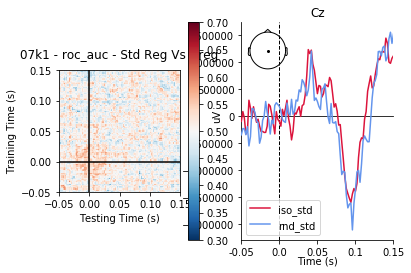

Subject : 08k1 
587 matching events found
0 projection items activated
0 bad epochs dropped


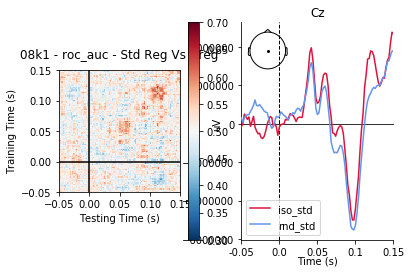

Subject : 09k1 
574 matching events found
0 projection items activated
0 bad epochs dropped


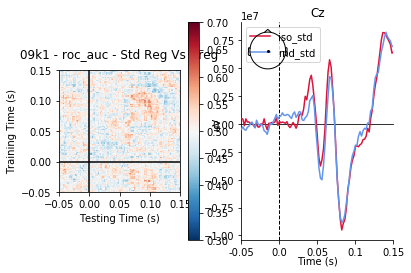

Subject : 10k1 
671 matching events found
0 projection items activated
0 bad epochs dropped


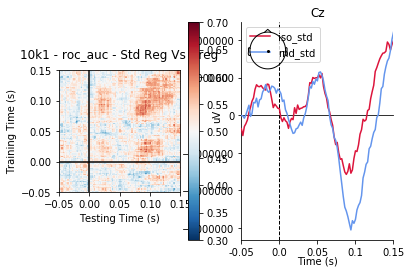

Subject : 11k1 
679 matching events found
0 projection items activated
0 bad epochs dropped


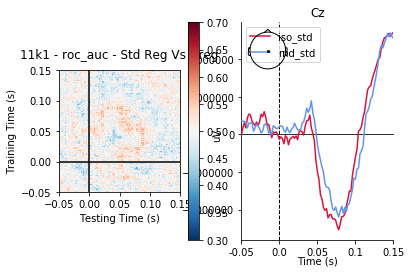

Subject : 12k1 
685 matching events found
0 projection items activated
0 bad epochs dropped


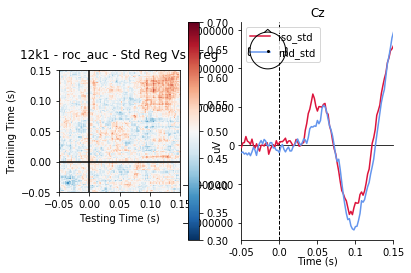

Subject : 13k1 
633 matching events found
0 projection items activated
0 bad epochs dropped


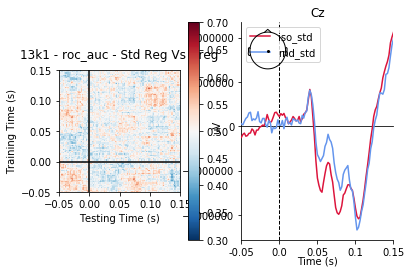

Subject : 14k1 
637 matching events found
0 projection items activated
0 bad epochs dropped


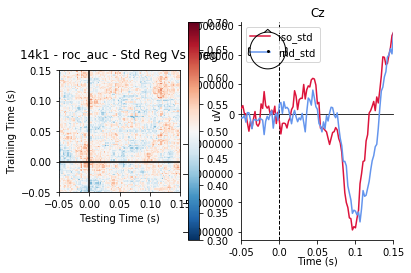

Subject : 15k1 
523 matching events found
0 projection items activated
0 bad epochs dropped


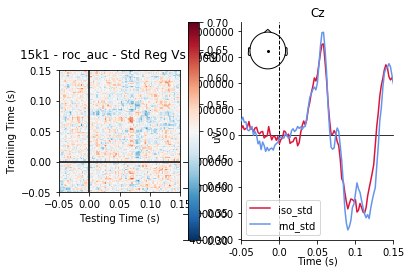

Subject : 16k1 
647 matching events found
0 projection items activated
0 bad epochs dropped


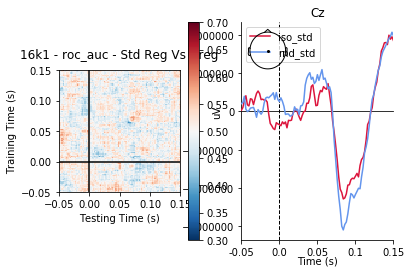

Subject : 17k1 
632 matching events found
0 projection items activated
0 bad epochs dropped


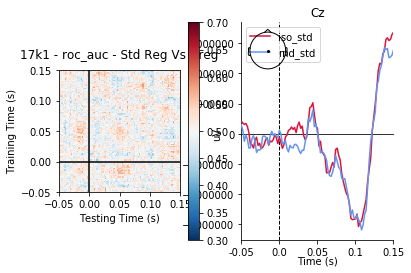

Subject : 18k1 
584 matching events found
0 projection items activated
0 bad epochs dropped


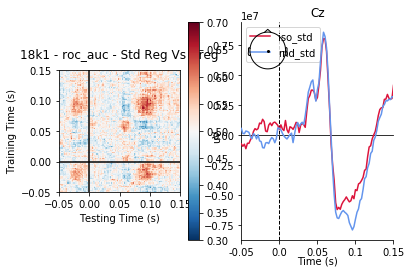

Subject : 19k1 
663 matching events found
0 projection items activated
0 bad epochs dropped


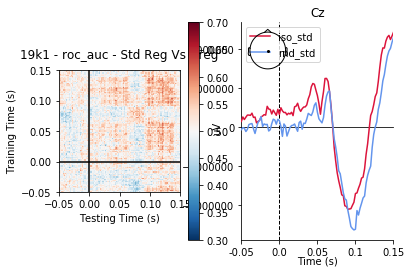

Subject : 20k1 
647 matching events found
0 projection items activated
0 bad epochs dropped


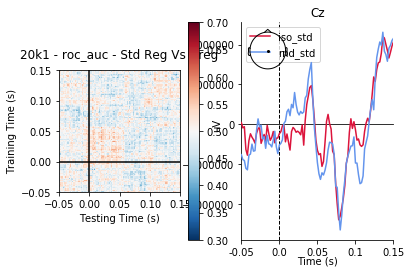

In [172]:
for matfile in allcontrols:
    curfile = os.path.join(datadir,'probands',matfile)
    subjid = curfile[-8:-4]
    
    fig,scores= timegen_process(curfile,metric='roc_auc')
    fig.set_figwidth(8)
    fig.set_figheight(8)
    fig.savefig('timegen_controls/%s.png' % subjid)
    plt.close(fig)
    
    

Subject : 01c1 
632 matching events found
0 projection items activated
0 bad epochs dropped


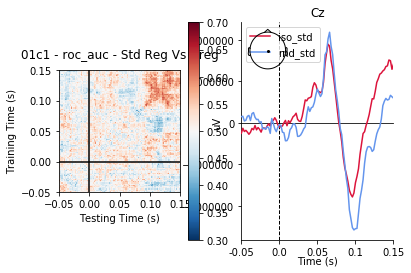

Subject : 01m1 
566 matching events found
0 projection items activated
0 bad epochs dropped


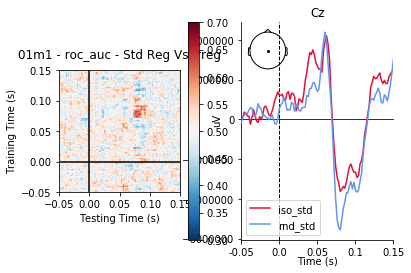

Subject : 02c1 
577 matching events found
0 projection items activated
0 bad epochs dropped


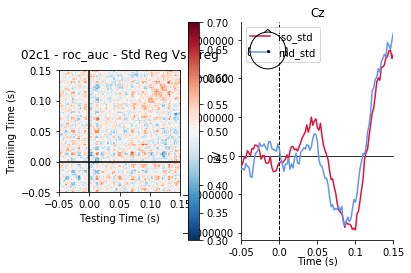

Subject : 02m1 
608 matching events found
0 projection items activated
0 bad epochs dropped


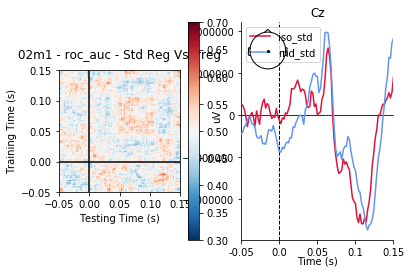

Subject : 03c1 
639 matching events found
0 projection items activated
0 bad epochs dropped


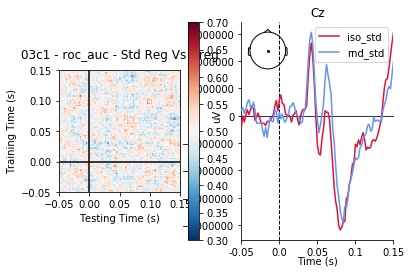

Subject : 03m1 
654 matching events found
0 projection items activated
0 bad epochs dropped


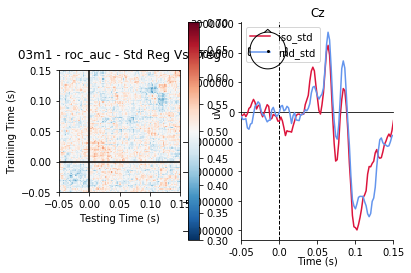

Subject : 04c1 
691 matching events found
0 projection items activated
0 bad epochs dropped


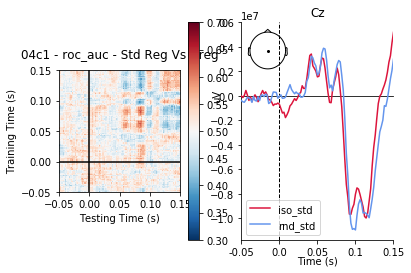

Subject : 04m1 
675 matching events found
0 projection items activated
0 bad epochs dropped


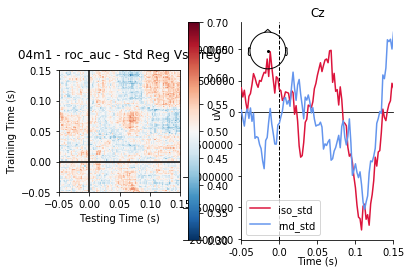

Subject : 05c1 
659 matching events found
0 projection items activated
0 bad epochs dropped


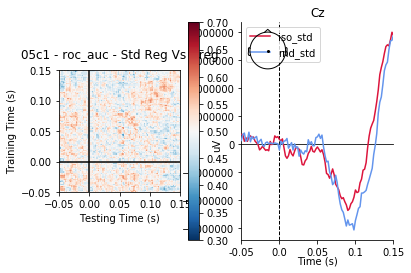

Subject : 06c1 
632 matching events found
0 projection items activated
0 bad epochs dropped


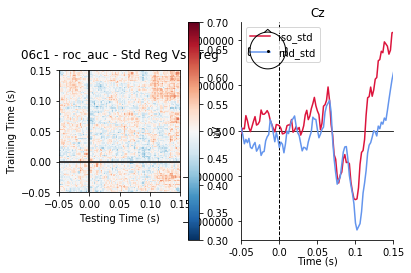

Subject : 07c1 
619 matching events found
0 projection items activated
0 bad epochs dropped


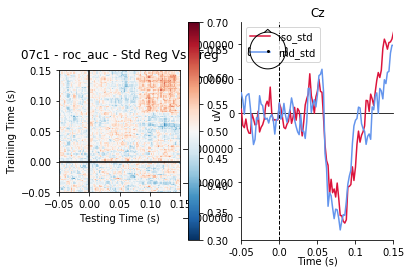

Subject : 08c1 
609 matching events found
0 projection items activated
0 bad epochs dropped


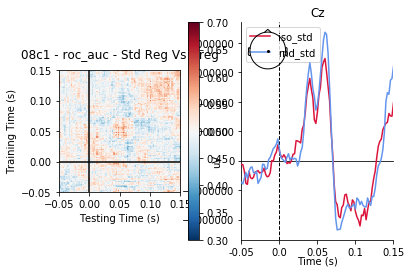

Subject : 09c1 
621 matching events found
0 projection items activated
0 bad epochs dropped


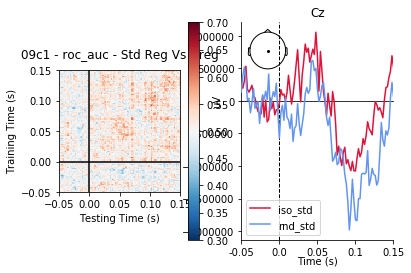

Subject : 10c1 
627 matching events found
0 projection items activated
0 bad epochs dropped


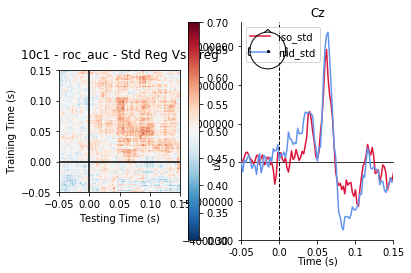

Subject : 11c1 
619 matching events found
0 projection items activated
0 bad epochs dropped


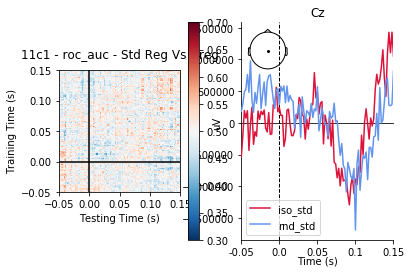

Subject : 12c1 
589 matching events found
0 projection items activated
0 bad epochs dropped


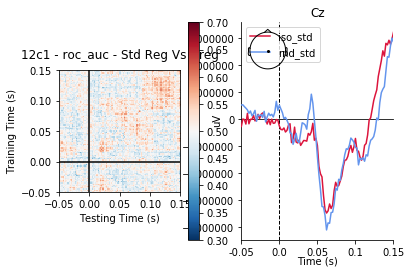

Subject : 13c1 
661 matching events found
0 projection items activated
0 bad epochs dropped


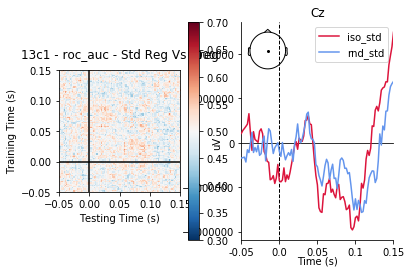

Subject : 14c1 
631 matching events found
0 projection items activated
0 bad epochs dropped


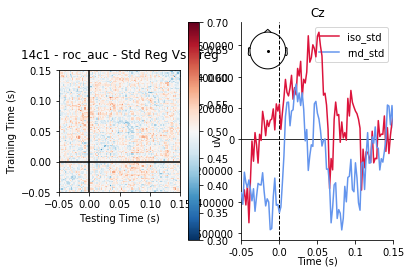

Subject : 15c1 
589 matching events found
0 projection items activated
0 bad epochs dropped


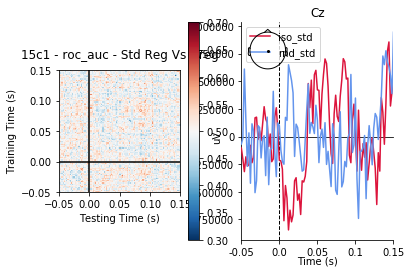

Subject : 17c1 
616 matching events found
0 projection items activated
0 bad epochs dropped


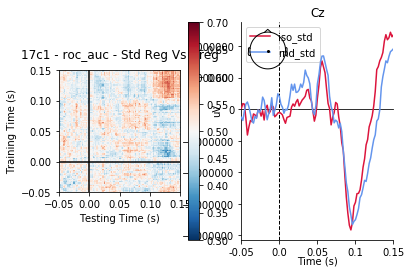

In [173]:
for matfile in allpatients:
    curfile = os.path.join(datadir,'patients',matfile)
    subjid = curfile[-8:-4]
    
    fig,scores= timegen_process(curfile,metric='roc_auc')
    fig.set_figwidth(8)
    fig.set_figheight(8)
    fig.savefig('timegen_patients/%s.png' % subjid)
    plt.close(fig)
    
    